## Setup

In [1]:
source("/path/to/the/project/02_notebooks/00_setup.r")

In [2]:
p_load("DESeq2", "dplyr", "EnhancedVolcano", "DEGreport", "ggpubr", "biomaRt", "caret", "mlbench", "biomaRt", "ggvenn", install = FALSE)

In [3]:
cir_hub <- read.csv("03_outputs/14/cir_hub.csv")
reg_hub <- read.csv("03_outputs/14/reg_hub.csv")
pp_hub <- read.csv("03_outputs/14/pp_hub.csv")
cpa_hub <- read.csv("03_outputs/14/cpa_hub.csv")

In [4]:
cir_hub <- cir_hub$from %>% toupper()
reg_hub <- reg_hub$from %>% toupper()
pp_hub <- pp_hub$from %>% toupper()
cpa_hub <- cpa_hub$from %>% toupper()

In [6]:
#source("https://raw.githubusercontent.com/HerpelinckT/geneset-modulescoring/main/modulescoring/geneset_modulescoring.R")

ggplotRegression <- function (fit) {
ggplot(fit$model, aes_string(x = names(fit$model)[2], y = names(fit$model)[1], color = names(fit$model)[2])) + 
  geom_point(shape = 16, size = 5, alpha = 0.8, show.legend = FALSE) +
  stat_smooth(method = "lm", col = "#5e2dbb") +
  labs(title = paste("Adj R2 = ",signif(summary(fit)$adj.r.squared, 5),
                     "Intercept =",signif(fit$coef[[1]],5 ),
                     " Slope =",signif(fit$coef[[2]], 5),
                     " P =",signif(summary(fit)$coef[2,4], 5))) +
                     theme_minimal() +
  scale_color_gradient(low = "#708090", high = "#063852")
}

### PRJEB27201

In [5]:
PRJEB27201_metadata <- read.csv("01_raw_data/validation/PRJEB27201/PRJEB27201_metadata.csv", row.names = 1)
PRJEB27201_expression_matrix <- read.csv(file = '01_raw_data/validation/PRJEB27201/PRJEB27201_counts.csv', row.names = 1)
PRJEB27201_metadata$METAVIR_score <- factor(PRJEB27201_metadata$METAVIR_score)
PRJEB27201_metadata$alcohol_consumption_measurement <- factor(PRJEB27201_metadata$alcohol_consumption_measurement)

In [6]:
PRJEB27201_metadata_clarified <- PRJEB27201_metadata
PRJEB27201_metadata_clarified$METAVIR_score <- as.numeric(as.character(PRJEB27201_metadata_clarified$METAVIR_score))
PRJEB27201_metadata_clarified$METAVIR_score[PRJEB27201_metadata_clarified$METAVIR_score == 3] <- 5
PRJEB27201_metadata_clarified$METAVIR_score[PRJEB27201_metadata_clarified$METAVIR_score == 4] <- 5
PRJEB27201_metadata_clarified$METAVIR_score <- as.factor(PRJEB27201_metadata_clarified$METAVIR_score)

In [7]:
 PRJEB27201_dds <- DESeqDataSetFromMatrix(countData = round(PRJEB27201_expression_matrix), colData = PRJEB27201_metadata_clarified,
   design = ~METAVIR_score)
# PRJEB27201_dds <- DESeqDataSetFromMatrix(countData = round(PRJEB27201_expression_matrix), colData = PRJEB27201_metadata,
#   design = ~disease_staging)
PRJEB27201_dds <- DESeq(PRJEB27201_dds)

converting counts to integer mode

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 492 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



### Overlaps

In [220]:
cir_results <- results(PRJEB27201_dds, contrast = c("METAVIR_score", "5", "0"))

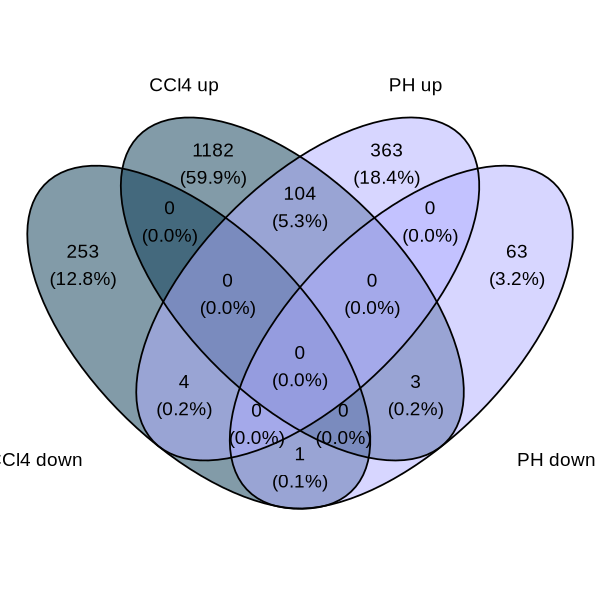

In [221]:
options(repr.plot.width = 5, repr.plot.height = 5)
venn_dataframe <- list("CCl4 down" = ccl4_c_down,
                       "CCl4 up" = ccl4_c_up,
                        "PH up" = rownames(cir_results %>% as.data.frame() %>% filter(padj <= 0.05 & log2FoldChange >= 0.5)),
                        "PH down" = rownames(cir_results %>% as.data.frame() %>% filter(padj <= 0.05 & log2FoldChange <= -0.5)))

ggvenn(venn_dataframe,
  fill_color = c("#063852", "#063852", "#afaeff", "#afaeff"),
  stroke_size = 0.5, set_name_size = 4)

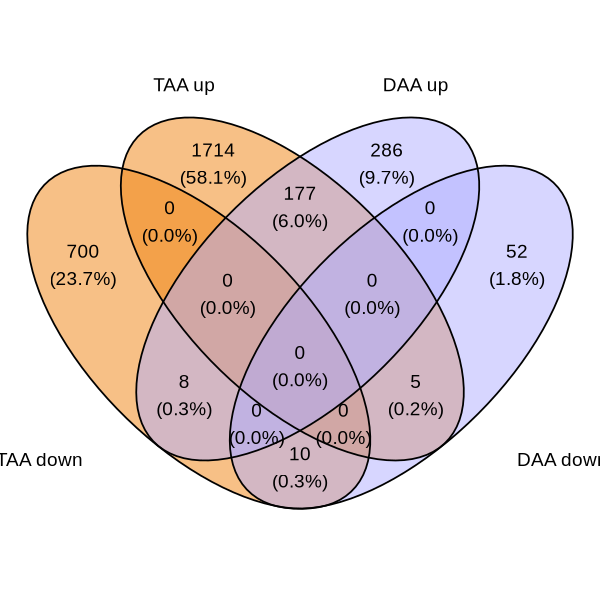

In [222]:
venn_dataframe <- list("TAA down" = taa_c_down,
                       "TAA up" = taa_c_up,
                        "DAA up" = rownames(cir_results %>% as.data.frame() %>% filter(padj <= 0.05 & log2FoldChange >= 0.5)),
                        "DAA down" = rownames(cir_results %>% as.data.frame() %>% filter(padj <= 0.05 & log2FoldChange <= -0.5)))

ggvenn(venn_dataframe,
  fill_color = c("#F0810F", "#F0810F", "#afaeff", "#afaeff"),
  stroke_size = 0.5, set_name_size = 4)

## GSE225740
https://pubmed.ncbi.nlm.nih.gov/36927865/

In [34]:
GSE225740_expression_matrix <- read.csv("01_raw_data/validation/GSE225740/counts.csv.gz", check.names = FALSE)
GSE225740_metadata <- read.csv(file = '01_raw_data/validation/GSE225740/meta.csv.gz')
GSE225740_metadata <- GSE225740_metadata %>% tidyr::drop_na()
GSE225740_metadata$nas <- factor(GSE225740_metadata$nas)
GSE225740_metadata$fibrosis <- factor(GSE225740_metadata$fibrosis)
GSE225740_metadata$steatohep <- factor(GSE225740_metadata$steatohep)


In [35]:
GSE225740_metadata <- GSE225740_metadata %>% mutate(fib_clarified = "") %>% mutate(fib_clarified = case_when(fibrosis == "3" ~ "5", fibrosis == "4" ~ "5", .default = as.character(fibrosis)))

In [36]:
mart <- useEnsembl(dataset = "hsapiens_gene_ensembl", biomart='ensembl')
ids = getBM(attributes = c('entrezgene_id', 'external_gene_name'), 
              filters = 'entrezgene_id', 
              values = GSE225740_expression_matrix$EntrezGene, 
              mart = mart)
ids <- ids %>% rename(EntrezGene = entrezgene_id) %>% distinct()

In [37]:
GSE225740_expression_matrix <- merge(GSE225740_expression_matrix, ids, by = "EntrezGene", all = TRUE) %>% tidyr::drop_na() %>% filter(! duplicated(external_gene_name)) %>% tibble::column_to_rownames("external_gene_name") %>% dplyr::select(-EntrezGene)
GSE225740_expression_matrix <- GSE225740_expression_matrix %>% dplyr::select(all_of(as.vector(GSE225740_metadata$pt..ID)))
GSE225740_metadata <- GSE225740_metadata %>% tibble::column_to_rownames("pt..ID")

In [38]:
GSE225740_dds <- DESeqDataSetFromMatrix(countData = GSE225740_expression_matrix, colData = GSE225740_metadata,
  design = ~fib_clarified)
GSE225740_dds <- DESeq(GSE225740_dds)

GSE225740_dds_nash <- DESeqDataSetFromMatrix(countData = GSE225740_expression_matrix, colData = GSE225740_metadata,
  design = ~steatohep)
GSE225740_dds_nash <- DESeq(GSE225740_dds_nash)

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 191 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 245 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



In [40]:
GSE225740_res <- results(GSE225740_dds, contrast = c("fib_clarified", "5", "0"))

### Overlaps

In [207]:
fib_results <- results(GSE225740_dds, contrast = c("fib_clarified", "5", "0"))

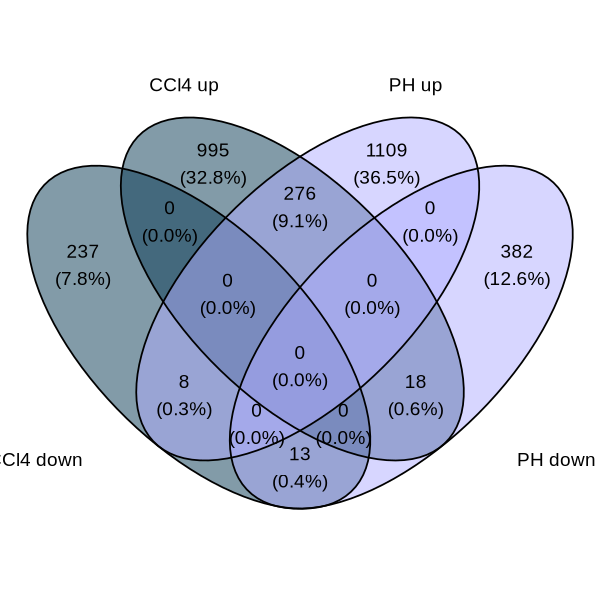

In [208]:
options(repr.plot.width = 5, repr.plot.height = 5)
venn_dataframe <- list("CCl4 down" = ccl4_c_down,
                       "CCl4 up" = ccl4_c_up,
                        "PH up" = rownames(fib_results %>% as.data.frame() %>% filter(padj <= 0.05 & log2FoldChange >= 0.5)),
                        "PH down" = rownames(fib_results %>% as.data.frame() %>% filter(padj <= 0.05 & log2FoldChange <= -0.5)))

ggvenn(venn_dataframe,
  fill_color = c("#063852", "#063852", "#afaeff", "#afaeff"),
  stroke_size = 0.5, set_name_size = 4)

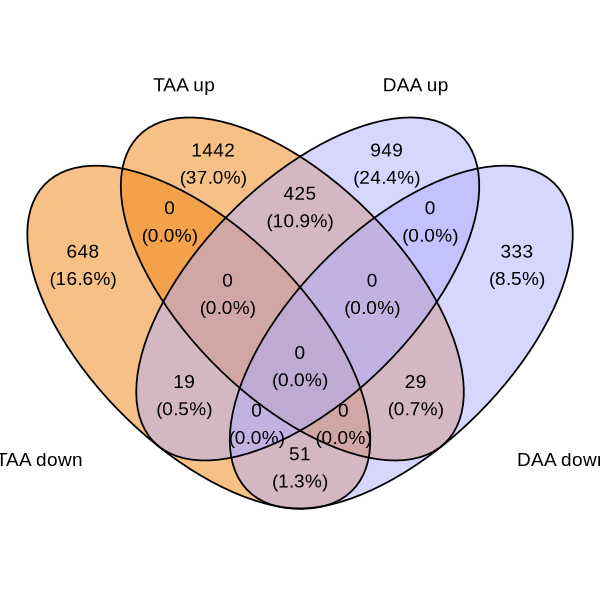

In [209]:
venn_dataframe <- list("TAA down" = taa_c_down,
                       "TAA up" = taa_c_up,
                        "DAA up" = rownames(fib_results %>% as.data.frame() %>% filter(padj <= 0.05 & log2FoldChange >= 0.5)),
                        "DAA down" = rownames(fib_results %>% as.data.frame() %>% filter(padj <= 0.05 & log2FoldChange <= -0.5)))

ggvenn(venn_dataframe,
  fill_color = c("#F0810F", "#F0810F", "#afaeff", "#afaeff"),
  stroke_size = 0.5, set_name_size = 4)

## GSE171248

In [14]:
CT15 <- read.delim("01_raw_data/validation/GSE171248/GSM5221317_CT15.tsv.gz") %>% rename(CT15 = MAT...i.)
CT16 <- read.delim("01_raw_data/validation/GSE171248/GSM5221318_CT16.tsv.gz") %>% rename(CT16 = MAT...i.)
CT18 <- read.delim("01_raw_data/validation/GSE171248/GSM5221319_CT18.tsv.gz") %>% rename(CT18 = MAT...i.)
CT23 <- read.delim("01_raw_data/validation/GSE171248/GSM5221320_CT23.tsv.gz") %>% rename(CT23 = MAT...i.)
CT2 <- read.delim("01_raw_data/validation/GSE171248/GSM5221321_CT2.tsv.gz") %>% rename(CT2 = MAT...i.)
CT47 <- read.delim("01_raw_data/validation/GSE171248/GSM5221322_CT47.tsv.gz") %>% rename(CT47 = MAT...i.)
CT62 <- read.delim("01_raw_data/validation/GSE171248/GSM5221323_CT62.tsv.gz") %>% rename(CT62 = MAT...i.)
CT6 <- read.delim("01_raw_data/validation/GSE171248/GSM5221324_CT6.tsv.gz") %>% rename(CT6 = MAT...i.)
CH15 <- read.delim("01_raw_data/validation/GSE171248/GSM5221325_CH15.tsv.gz") %>% rename(CH15 = MAT...i.)
CH30 <- read.delim("01_raw_data/validation/GSE171248/GSM5221326_CH30.tsv.gz") %>% rename(CH30 = MAT...i.)
CH3 <- read.delim("01_raw_data/validation/GSE171248/GSM5221327_CH3.tsv.gz") %>% rename(CH3 = MAT...i.)
CH43 <- read.delim("01_raw_data/validation/GSE171248/GSM5221328_CH43.tsv.gz") %>% rename(CH43 = MAT...i.)
CH50 <- read.delim("01_raw_data/validation/GSE171248/GSM5221329_CH50.tsv.gz") %>% rename(CH50 = MAT...i.)
CH60 <- read.delim("01_raw_data/validation/GSE171248/GSM5221330_CH60.tsv.gz") %>% rename(CH60 = MAT...i.)
CH66 <- read.delim("01_raw_data/validation/GSE171248/GSM5221331_CH66.tsv.gz") %>% rename(CH66 = MAT...i.)
CH68 <- read.delim("01_raw_data/validation/GSE171248/GSM5221332_CH68.tsv.gz") %>% rename(CH68 = MAT...i.)

In [15]:
pp_samples <- list(CT15, CT16, CT18, CT23, CT2, CT47, CT62, CT6, CH15, CH30, CH3, CH43, CH50, CH60, CH66, CH68) %>% purrr::reduce(left_join, by='ID')

In [16]:
pp_samples <- pp_samples %>% tidyr::separate(ID, into = c("ensembl", "gene"), sep = "_") %>% dplyr::select(-ensembl)
pp_samples <- pp_samples %>% distinct() %>% filter(!gene %in% c('ACA59', 'ALG1L9P', 'BCRP3', 'BMS1P4', 'BTBD8', 'C2orf61', 'C2orf81', 'CLRN1-AS1', 'COG8', 'CPEB3', 'CTSLP2', 'CYB561D2', 'DGCR5', 'DLEU1', 'DLEU2', 'DLX6-AS1', 'DNAJC9-AS1', 'DUXAP8', 'ELFN2', 'EMG1', 'FAM13A-AS1', 'FMR1-AS1', 'FTX', 'GABARAPL3', 'GHRLOS', 'GNAS-AS1', 'GOLGA8M', 'H19', 'HAR1A', 'HIST1H3D', 'HOTAIRM1', 'HTT-AS1', 'HULC', 'JPX', 'KBTBD11-OT1', 'KCNQ1OT1', 'LINC00484', 'LINC01238', 'LINC01297', 'LINC01347', 'LINC01422', 'LINC01481', 'LINC01505', 'LINC01598', 'LYNX1', 'MAL2', 'MALAT1', 'MATR3', 'MEG3', 'MEG8', 'MESTIT1', 'MIAT', 'MIR130B', 'MIR1539', 'MIR219A2', 'MIR3179-1', 'MIR3179-3', 'MIR3180-1', 'MIR3180-2', 'MIR3180-3', 'MIR3180-4', 'Metazoa', 'NBPF13P', 'NEAT1', 'NPPA-AS1', 'OR7E47P', 'PAR', 'PCA3', 'PDXDC2P', 'PMS2P6', 'POLR2J2', 'POLR2J4', 'PRICKLE2-AS1', 'PROX1-AS1', 'PRSS50', 'PVT1', 'RABGEF1', 'RAET1E-AS1', 'RGS5', 'RMRP', 'RMST', 'RN7SL1', 'RNU12', 'RP1-232L22', 'RP11-59D5', 'RPPH1', 'SCARNA10', 'SCARNA15', 'SCARNA16', 'SCARNA2', 'SCARNA6', 'SCO2', 'SDHD', 'SMAD5-AS1', 'SMCR2', 'SNORA12', 'SNORA17B', 'SNORA4', 'SNORA57', 'SNORA62', 'SNORA67', 'SNORA81', 'SOGA3', 'SOX2OT', 'SPATA13', 'SPRY4-IT1', 'ST7-AS1', 'ST7-AS2', 'ST7-OT4', 'TCL6', 'TP53TG1', 'TP73-AS1', 'TTC28-AS1', 'TUG1', 'TXNRD3NB', 'U1', 'U3', 'UCA1', 'WT1-AS', 'XIST', 'XXyac-YX65C7', 'ZEB2', 'ZFAT-AS1', 'uc'))
pp_samples <- pp_samples %>% tibble::column_to_rownames("gene")


In [17]:
pp_samples <- pp_samples %>% as.matrix()
storage.mode(pp_samples) <- "integer"

In [18]:
pp_meta <- data.frame(patient = c("CT15", "CT16", "CT18", "CT23", "CT2", "CT27", "CT62", "CT6", "CH15", "CH30", "CH3", "CH43", "CH50", "CH60", "CH66", "CH68"), 
                        group = c("HC", "HC", "HC", "HC", "HC", "HC", "HC", "HC", "CIR", "CIR", "CIR", "CIR", "CIR", "CIR", "CIR", "CIR"))

In [19]:
pp_meta$group <- factor(pp_meta$group)

In [20]:
GSE171248_dds <- DESeqDataSetFromMatrix(countData = pp_samples, colData = pp_meta,
  design = ~group)
GSE171248_dds <- DESeq(GSE171248_dds)

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 262 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



In [79]:
GSE171248_res <- res(GSE171248_dds, type="ashr", contrast = c("group", "CIR", "HC"))

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041



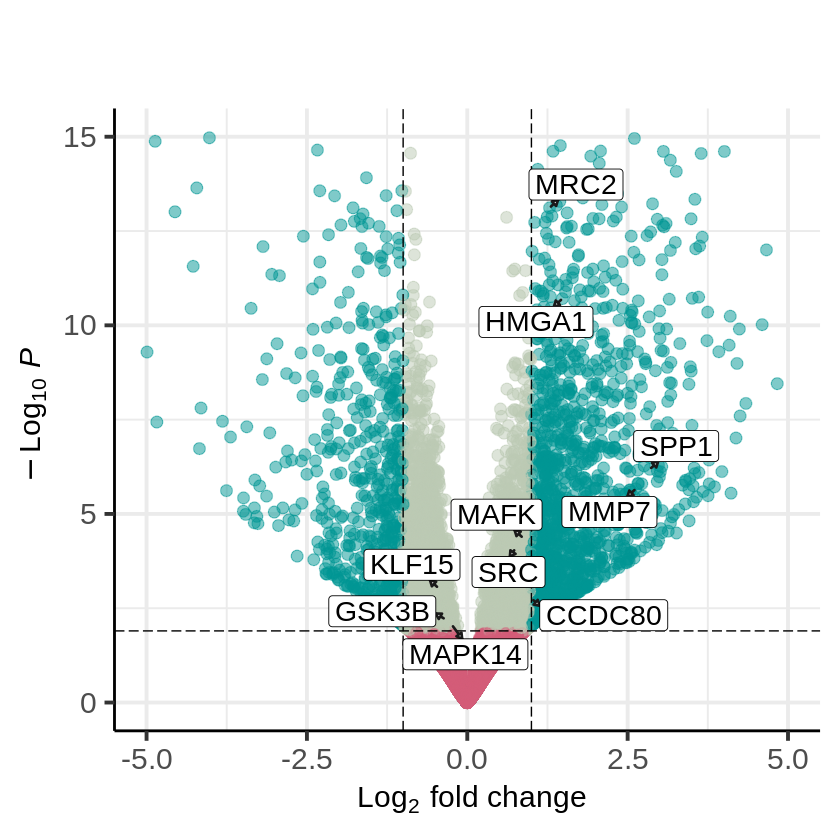

In [81]:
pp_cir <- EnhancedVolcano(GSE171248_res,
                lab = rownames(GSE171248_res),
                x = "log2FoldChange",
                selectLab = c("MRC2", "HMGA1", "SPP1", "MMP7", "MAFK", "SRC", "CCDC80", "KLF15", "GSK3B", "MAPK14"), #CIR
                xlim = c(-5, 5),
                y = "pvalue",
                pCutoffCol = "padj",
               ylim = c(0, 15),
                title = "",
                subtitle = "",
                caption = NULL,
                pCutoff = 0.05,
                FCcutoff = 1,
                pointSize = 3.0,
                labSize = 6.0,
                drawConnectors = TRUE,
                widthConnectors = 0.75,
                max.overlaps = 20,
                boxedLabels = TRUE,
                col=hcl.colors(4, "TealRose", rev = TRUE)
               ) + theme(legend.position = "none")
pp_cir

Warning message:
"ggrepel: 16 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


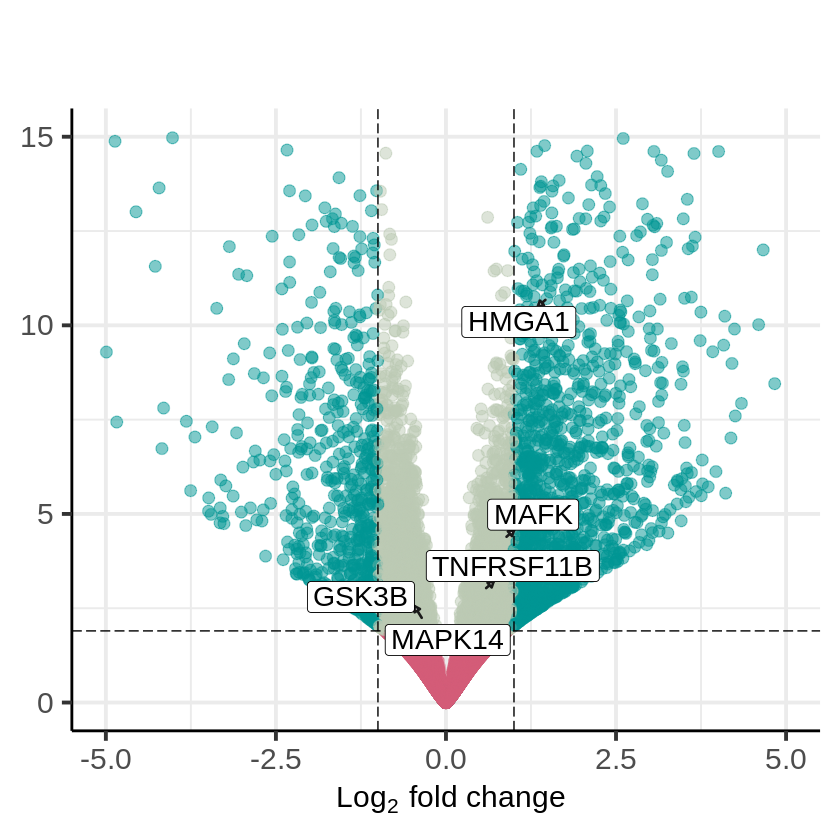

In [85]:
pp_cpa <- EnhancedVolcano(GSE171248_res,
                lab = rownames(GSE171248_res),
                x = "log2FoldChange",
                selectLab = cpa_hub, #CPA
                xlim = c(-5, 5),
                y = "pvalue",
                pCutoffCol = "padj",
               ylim = c(0, 15),
                title = "",
                subtitle = "",
                caption = NULL,
                ylab = NULL,
                pCutoff = 0.05,
                FCcutoff = 1,
                pointSize = 3.0,
                labSize = 6.0,
                drawConnectors = TRUE,
                widthConnectors = 0.75,
                max.overlaps = 20,
                boxedLabels = TRUE,
                col=hcl.colors(4, "TealRose", rev = TRUE)
               ) + theme(legend.position = "none")

pp_cpa

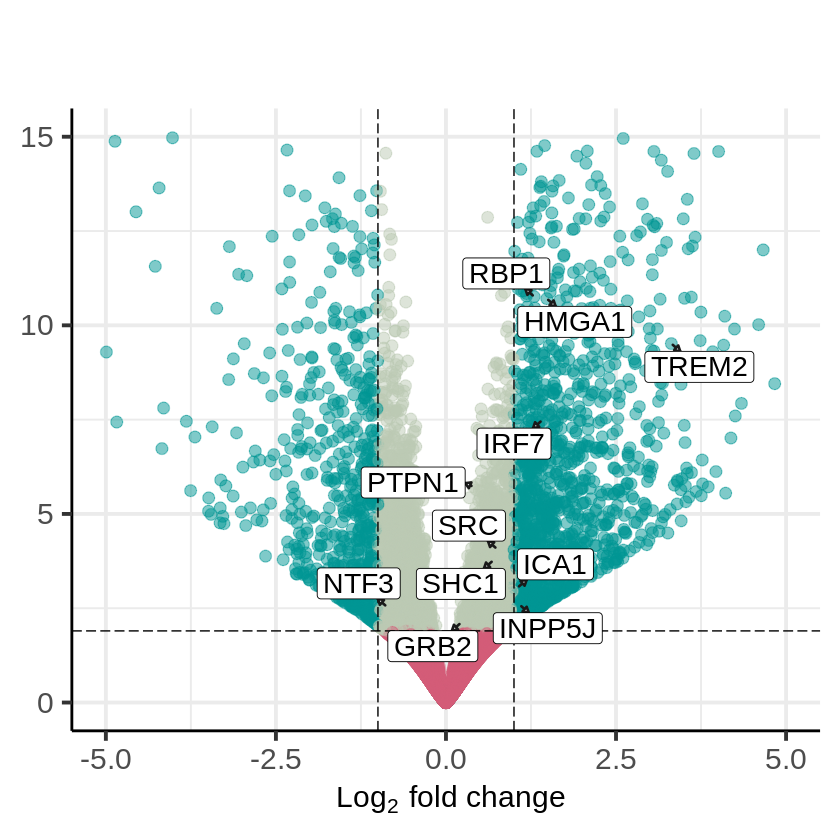

In [87]:
pp_pp <- EnhancedVolcano(GSE171248_res,
                lab = rownames(GSE171248_res),
                x = "log2FoldChange",
                selectLab = c("RBP1", "HMGA1", "TREM2", "IRF7", "PTPN1", "SRC", "SHC1", "ICA1", "INPP5J", "NTF3", "GRB2"), #PP
                xlim = c(-5, 5),
                y = "pvalue",
                pCutoffCol = "padj",
               ylim = c(0, 15),
                title = "",
                subtitle = "",
                caption = NULL,
                ylab = NULL,
                pCutoff = 0.05,
                FCcutoff = 1,
                pointSize = 3.0,
                labSize = 6.0,
                drawConnectors = TRUE,
                widthConnectors = 0.75,
                max.overlaps = 20,
                boxedLabels = TRUE,
                col=hcl.colors(4, "TealRose", rev = TRUE)
               ) + theme(legend.position = "none")
pp_pp


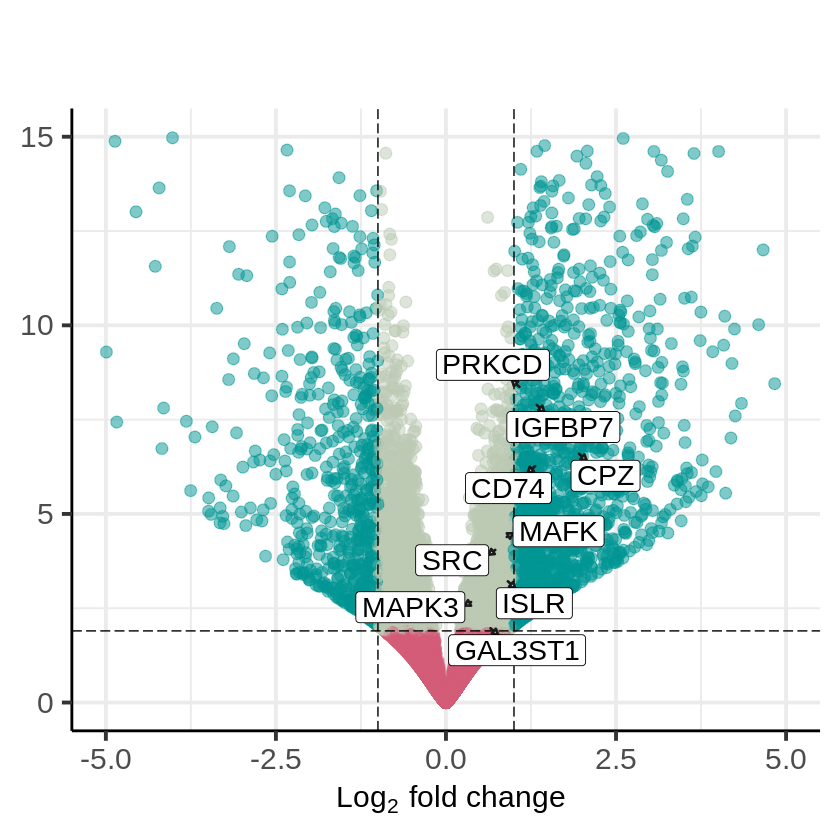

In [90]:
pp_reg <- EnhancedVolcano(GSE171248_res,
                lab = rownames(GSE171248_res),
                x = "log2FoldChange",
                selectLab = c("PRKCD", "IGFBP7", "CPZ", "CD74", "MAFK", "SRC", "ISLR", "MAPK3", "GAL3ST1"), #R
                xlim = c(-5, 5),
                y = "pvalue",
                pCutoffCol = "padj",
               ylim = c(0, 15),
                title = "",
                subtitle = "",
                caption = NULL,
                ylab = NULL,
                pCutoff = 0.05,
                FCcutoff = 1,
                pointSize = 3.0,
                labSize = 6.0,
                drawConnectors = TRUE,
                widthConnectors = 0.75,
                max.overlaps = 20,
                boxedLabels = TRUE,
                col=hcl.colors(4, "TealRose", rev = TRUE)
               ) + theme(legend.position = "none")

pp_reg

### Overlaps

In [187]:
ph_results <- results(GSE171248_dds, contrast = c("group", "CIR", "HC"))

In [188]:
ph_results

log2 fold change (MLE): group CIR vs HC 
Wald test p-value: group CIR vs HC 
DataFrame with 56234 rows and 6 columns
                baseMean log2FoldChange     lfcSE      stat      pvalue
               <numeric>      <numeric> <numeric> <numeric>   <numeric>
TSPAN6        1822.66612      -0.255684  0.163063 -1.568001 1.16881e-01
TNMD             2.51559      -0.606417  1.478082 -0.410273 6.81606e-01
DPM1           562.12086      -0.049399  0.115662 -0.427099 6.69307e-01
SCYL3          436.20465      -0.154084  0.125398 -1.228756 2.19163e-01
C1orf112       124.91339      -1.430698  0.264657 -5.405858 6.44988e-08
...                  ...            ...       ...       ...         ...
RP11-71G12.2           0             NA        NA        NA          NA
MIR7847                0             NA        NA        NA          NA
MIR6785                0             NA        NA        NA          NA
MIR4467                0             NA        NA        NA          NA
RP11-755H23.1      

In [ ]:
cured_cir_genes <- cured_results %>% as.data.frame %>% filter(pvalue < 0.05)  %>% filter(rownames(.) %in% c(cir_hub)) %>% rownames(.)
cured_reg_genes <- cured_results %>% as.data.frame %>% filter(pvalue < 0.05)  %>% filter(rownames(.) %in% c(reg_hub)) %>% rownames(.)
cured_pp_genes <- cured_results %>% as.data.frame %>% filter(pvalue < 0.05) %>% filter(rownames(.) %in% c(pp_hub)) %>% rownames(.)
cured_cpa_genes <- cured_results %>% as.data.frame %>% filter(pvalue < 0.05) %>% filter(rownames(.) %in% c(cpa_hub)) %>% rownames(.)

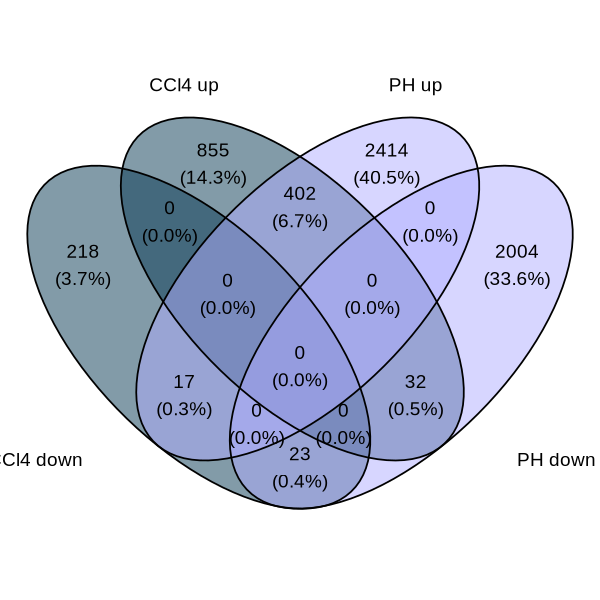

In [189]:
options(repr.plot.width = 5, repr.plot.height = 5)
venn_dataframe <- list("CCl4 down" = ccl4_c_down,
                       "CCl4 up" = ccl4_c_up,
                        "PH up" = rownames(ph_results %>% as.data.frame() %>% filter(padj <= 0.05 & log2FoldChange >= 0.5)),
                        "PH down" = rownames(ph_results %>% as.data.frame() %>% filter(padj <= 0.05 & log2FoldChange <= -0.5)))

ggvenn(venn_dataframe,
  fill_color = c("#063852", "#063852", "#afaeff", "#afaeff"),
  stroke_size = 0.5, set_name_size = 4)

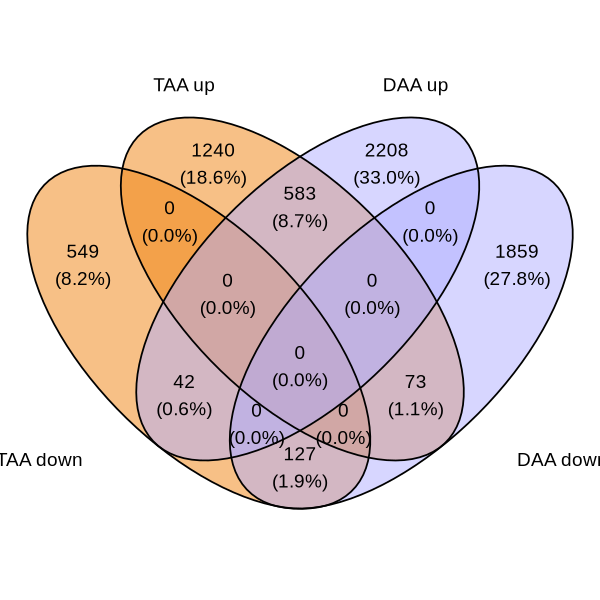

In [190]:
venn_dataframe <- list("TAA down" = taa_c_down,
                       "TAA up" = taa_c_up,
                        "DAA up" = rownames(ph_results %>% as.data.frame() %>% filter(padj <= 0.05 & log2FoldChange >= 0.5)),
                        "DAA down" = rownames(ph_results %>% as.data.frame() %>% filter(padj <= 0.05 & log2FoldChange <= -0.5)))

ggvenn(venn_dataframe,
  fill_color = c("#F0810F", "#F0810F", "#afaeff", "#afaeff"),
  stroke_size = 0.5, set_name_size = 4)

## Models

### Predict disease staging in PRJEB27201

In [8]:
to_metadata_columns_disease_staging <- t(subset(assay(vst(PRJEB27201_dds)), rownames(PRJEB27201_dds) %in% c("SCUBE1", "SPP1", "MMP7", "TCF4", "SRC", "PRKG1", "ARHGAP44", "CPZ", "ISLR", "TCF4"))) %>% 
                                as.data.frame() %>% tibble::rownames_to_column("Sample_id")

metadata_disease_staging <- PRJEB27201_metadata
metadata_disease_staging <- metadata_disease_staging %>% tibble::rownames_to_column("Sample_id")
metadata_disease_staging <- metadata_disease_staging %>% dplyr::select(c("Sample_id", "disease_staging"))
metadata_disease_staging <- merge(metadata_disease_staging, to_metadata_columns_disease_staging, by = "Sample_id")
metadata_disease_staging$disease_staging[metadata_disease_staging$disease_staging == "early"] <- 0
metadata_disease_staging$disease_staging[metadata_disease_staging$disease_staging == "advanced"] <- 1
metadata_disease_staging$disease_staging <- as.factor(metadata_disease_staging$disease_staging)
x_train_disease_staging <- metadata_disease_staging[,-2]
y_train_disease_staging <- metadata_disease_staging[, 2]

In [10]:
control_rfe_disease_staging = rfeControl(functions = nbFuncs, # random forest
                      method = "repeatedcv", # repeated cv
                      repeats = 5, # number of repeats
                      number = 10) # number of folds

set.seed(42)
# Performing RFE
defaultW <- getOption("warn") 
options(warn = -1)
result_rfe_disease_staging = rfe(x = x_train_disease_staging %>% dplyr::select(-Sample_id), 
                 y = y_train_disease_staging, 
                 sizes = c(1:10),
                 rfeControl = control_rfe_disease_staging)

# result_rfe_disease_staging = train(x = x_train_disease_staging %>% dplyr::select(-Sample_id), 
#                  method = "rf",
#                  y = y_train_disease_staging, 
#                  sizes = c(1:10),
#                  trControl = control_rfe_disease_staging)

# summarising the results
result_rfe_disease_staging
options(warn = defaultW)


Recursive feature selection

Outer resampling method: Cross-Validated (10 fold, repeated 5 times) 

Resampling performance over subset size:

 Variables Accuracy  Kappa AccuracySD KappaSD Selected
         1   0.6575 0.1801     0.1038  0.2512         
         2   0.6894 0.2752     0.1372  0.3280         
         3   0.6862 0.2771     0.1666  0.3865         
         4   0.6843 0.2703     0.1755  0.4017         
         5   0.6794 0.2707     0.1669  0.3800         
         6   0.6987 0.3087     0.1676  0.3889         
         7   0.7043 0.3251     0.1690  0.3885        *
         8   0.6775 0.2687     0.1467  0.3431         
         9   0.6837 0.2749     0.1550  0.3654         

The top 5 variables (out of 7):
   CPZ, ARHGAP44, SRC, PRKG1, ISLR


In [11]:
result_rfe_disease_staging$optVariables

[1] "CPZ"      "ARHGAP44" "SRC"      "PRKG1"    "ISLR"     "SPP1"     "TCF4"

In [12]:
roc_control = trainControl(method = 'LOOCV',                
                        number = 1,
                        seed = as.list(rep(1,70)),
                         savePredictions = 'final',        
                        ) # number of folds


roc_pred_stage <- train(disease_staging ~ CPZ + ARHGAP44 + SRC + PRKG1 + ISLR + SPP1 + TCF4, 
                 data = metadata_disease_staging,
                 method = "rf",
                 trControl = roc_control,
                 tuneGrid=data.frame(mtry=1))
roc_pred_stage

Random Forest 

69 samples
 7 predictor
 2 classes: '0', '1' 

No pre-processing
Resampling: Leave-One-Out Cross-Validation 
Summary of sample sizes: 68, 68, 68, 68, 68, 68, ... 
Resampling results:

  Accuracy   Kappa    
  0.7101449  0.3484419

Tuning parameter 'mtry' was held constant at a value of 1

### Predict cirrhosis in GSE171248

In [21]:
hubs_1248_1 <- c("MRC2", "HMGA1", "SPP1", "MMP7", "MAFK", "SRC", "CCDC80", "KLF15", "GSK3B", "MAPK14")
hubs_1248_2 <- c("HMGA1", "MAFK", "TNFRSF11B", "GSK3B", "MAPK14")
hubs_1248_3 <- c("RBP1", "HMGA1", "TREM2", "IRF7", "PTPN1", "SRC", "SHC1", "ICA1", "INPP5J", "NTF3", "GRB2")
hubs_1248_4 <- c("PRKCD", "IGFBP7", "CPZ", "CD74", "MAFK", "SRC", "ISLR", "MAPK3", "GAL3ST1")

hubs_1248 <- c(hubs_1248_1, hubs_1248_2, hubs_1248_3, hubs_1248_4)
hubs_1248 <- unique(hubs_1248)

In [22]:
to_metadata_columns_group <- t(subset(assay(GSE171248_dds), rownames(GSE171248_dds) %in% c(hubs_1248))) %>% 
                as.data.frame() %>% tibble::rownames_to_column("Sample_id")

metadata_group <- pp_meta
metadata_group <- metadata_group %>% rename(Sample_id = patient)
metadata_group <- metadata_group %>% dplyr::select(c("Sample_id", "group"))
metadata_group <- merge(metadata_group, to_metadata_columns_group, by = "Sample_id")
metadata_group$group <- as.character(metadata_group$group)
metadata_group$group[metadata_group$group == "HC"] <- "0"
metadata_group$group[metadata_group$group == "CIR"] <- "1"
metadata_group$group <- as.factor(metadata_group$group)
x_train_group <- metadata_group[,-2]
y_train_group <- metadata_group[, 2]
control_rfe_group = rfeControl(functions = nbFuncs, # random forest
                      method = "repeatedcv", # repeated cv
                      repeats = 5, # number of repeats
                      number = 10) # number of folds

set.seed(42)
# Performing RFE
defaultW <- getOption("warn") 
options(warn = -1)
result_rfe_group = rfe(x = x_train_group %>% dplyr::select(-Sample_id), 
                 y = y_train_group, 
                 sizes = c(1:10),
                 rfeControl = control_rfe_group)

result_rfe_group

options(warn = defaultW)
result_rfe_group$optVariables
roc_control = trainControl(method = 'LOOCV',                
                        number = 1,
                        seed = as.list(rep(1,70)),
                         savePredictions = 'final',        
                        ) # number of folds




Recursive feature selection

Outer resampling method: Cross-Validated (10 fold, repeated 5 times) 

Resampling performance over subset size:

 Variables Accuracy  Kappa AccuracySD KappaSD Selected
         1   0.8854 0.6897     0.2576  0.4708         
         2   0.8333 0.5172     0.2793  0.5085         
         3   0.8438 0.5517     0.2759  0.5061         
         4   0.8646 0.6207     0.2678  0.4938         
         5   0.8854 0.6897     0.2576  0.4708         
         6   0.8854 0.6897     0.2576  0.4708         
         7   0.8854 0.6897     0.2576  0.4708         
         8   0.9062 0.7586     0.2453  0.4355         
         9   0.9271 0.8276     0.2304  0.3844        *
        10   0.9271 0.8276     0.2304  0.3844         
        27   0.9271 0.8276     0.2304  0.3844         

The top 5 variables (out of 9):
   CPZ, HMGA1, IRF7, MRC2, PRKCD


[1] "CPZ"   "HMGA1" "IRF7"  "MRC2"  "PRKCD" "TREM2" "CD74"  "ISLR"  "RBP1"

In [31]:
roc_pred_stage <- train(group ~ ISLR + HMGA1 + IRF7 + MMP7, 
                 data = metadata_group,
                 method = "rf",
                 trControl = roc_control,
                 tuneGrid=data.frame(mtry=1))
roc_pred_stage

Random Forest 

15 samples
 4 predictor
 2 classes: '0', '1' 

No pre-processing
Resampling: Leave-One-Out Cross-Validation 
Summary of sample sizes: 14, 14, 14, 14, 14, 14, ... 
Resampling results:

  Accuracy   Kappa    
  0.9333333  0.8672566

Tuning parameter 'mtry' was held constant at a value of 1

### Predict F0 vs F3-F4 in GSE225740

In [32]:
hub_5740 <- c("MRC2", "MMP7", "KLF15", "TIMD4", "FGFRL1", "TREM2", "CPZ", "IGFBP7", "RCN3", "ISLR", "KLF15", "MMP7", "SPP1", "MRC2", "CCDC80", "SCUBE1", "TCF4", "SRC", "FGFRL1", "TCF4", "EGR1", "TIMPD4", "HHIP", "ARHGEF2", "TREM2", "TCF4", "INPP5J", "CPZ", "IGFBP7", "RCN3", "ISLR", "TCF4", "MAFK", "SRC")
hub_5740 <- unique(hub_5740)

In [39]:
metadata_fib <- GSE225740_metadata
metadata_fib <- metadata_fib %>% tibble::rownames_to_column("Sample_id")
metadata_fib <- metadata_fib %>% dplyr::select(c("Sample_id", "fib_clarified"))

In [40]:
to_metadata_columns_fib  <- t(subset(assay(vst(GSE225740_dds)), rownames(GSE225740_dds) %in% hub_5740)) %>% 
                                as.data.frame() %>% tibble::rownames_to_column("Sample_id")

metadata_fib <- GSE225740_metadata
metadata_fib <- metadata_fib %>% tibble::rownames_to_column("Sample_id")
metadata_fib <- metadata_fib %>% dplyr::select(c("Sample_id", "fib_clarified"))

In [41]:
metadata_fib <- metadata_fib %>% filter(fib_clarified %in% c(0, 5))
to_metadata_columns_fib <- to_metadata_columns_fib %>% filter(Sample_id %in% metadata_fib$Sample_id)

In [42]:
to_metadata_columns_fib  <- t(subset(assay(vst(GSE225740_dds)), rownames(GSE225740_dds) %in% hub_5740)) %>% 
                                as.data.frame() %>% tibble::rownames_to_column("Sample_id")

metadata_fib <- GSE225740_metadata
metadata_fib <- metadata_fib %>% tibble::rownames_to_column("Sample_id")
metadata_fib <- metadata_fib %>% dplyr::select(c("Sample_id", "fib_clarified"))
metadata_fib <- metadata_fib %>% filter(fib_clarified %in% c(0, 5))
to_metadata_columns_fib <- to_metadata_columns_fib %>% filter(Sample_id %in% metadata_fib$Sample_id)
metadata_fib <- merge(metadata_fib, to_metadata_columns_fib , by = "Sample_id")
metadata_fib$fib_clarified <- factor(metadata_fib$fib_clarified)
metadata_fib <- metadata_fib %>% dplyr::select(-Sample_id)
x_train_fib <- metadata_fib[,-1]
y_train_fib <- metadata_fib[, 1]
control_rfe_fib = rfeControl(functions = nbFuncs, # random forest
                      method = "repeatedcv", # repeated cv
                      repeats = 5, # number of repeats
                      number = 10) # number of folds

set.seed(42)

# Performing RFE
defaultW <- getOption("warn") 
options(warn = -1)
result_rfe_fib = rfe(x = x_train_fib, 
                 y = y_train_fib, 
                 sizes = c(1:10),
                 rfeControl = control_rfe_fib)

result_rfe_fib

options(warn = defaultW)
result_rfe_fib$optVariables
roc_control = trainControl(method = 'LOOCV',                
                        number = 1,
                        seed = as.list(rep(1,70)),
                         savePredictions = 'final',        
                        ) # number of folds


Recursive feature selection

Outer resampling method: Cross-Validated (10 fold, repeated 5 times) 

Resampling performance over subset size:

 Variables Accuracy  Kappa AccuracySD KappaSD Selected
         1   0.8030 0.5562     0.1745  0.3893         
         2   0.7907 0.5586     0.1971  0.3943         
         3   0.7713 0.5167     0.1891  0.4051         
         4   0.7277 0.4444     0.2178  0.4312         
         5   0.7387 0.4696     0.2107  0.4225         
         6   0.7407 0.4689     0.2235  0.4524         
         7   0.7407 0.4689     0.2177  0.4410         
         8   0.7607 0.5148     0.2213  0.4437         
         9   0.7647 0.5224     0.2202  0.4409         
        10   0.7737 0.5397     0.2176  0.4339         
        20   0.8313 0.6530     0.1786  0.3651        *

The top 5 variables (out of 20):
   CPZ, IGFBP7, SPP1, RCN3, CCDC80


[1] "CPZ"     "IGFBP7"  "SPP1"    "RCN3"    "CCDC80"  "MMP7"    "KLF15"  
 [8] "MRC2"    "EGR1"    "ISLR"    "TREM2"   "TCF4"    "FGFRL1"  "INPP5J" 
[15] "SRC"     "ARHGEF2" "HHIP"    "MAFK"    "SCUBE1"  "TIMD4"

In [46]:
roc_pred_fib <- train(fib_clarified ~ CPZ + IGFBP7 + SPP1 + CCDC80 + MMP7 + KLF15 + MRC2, 
                 data = metadata_fib,
                 method = "rf",
                 trControl = roc_control,
                 tuneGrid=data.frame(mtry=1))
roc_pred_fib

Random Forest 

46 samples
 7 predictor
 2 classes: '0', '5' 

No pre-processing
Resampling: Leave-One-Out Cross-Validation 
Summary of sample sizes: 45, 45, 45, 45, 45, 45, ... 
Resampling results:

  Accuracy   Kappa   
  0.7608696  0.502947

Tuning parameter 'mtry' was held constant at a value of 1

### Predict steatosis in GSE225740

In [ ]:
hub_5740 <- c("MRC2", "MMP7", "KLF15", "TIMD4", "FGFRL1", "TREM2", "CPZ", "IGFBP7", "RCN3", "ISLR", "KLF15", "MMP7", "SPP1", "MRC2", "CCDC80", "SCUBE1", "TCF4", "SRC", "FGFRL1", "TCF4", "EGR1", "TIMPD4", "HHIP", "ARHGEF2", "TREM2", "TCF4", "INPP5J", "CPZ", "IGFBP7", "RCN3", "ISLR", "TCF4", "MAFK", "SRC")
hub_5740 <- unique(hub_5740)

In [256]:
to_metadata_columns_st  <- t(subset(assay(vst(GSE225740_dds)), rownames(GSE225740_dds) %in% hub_5740)) %>% 
                                as.data.frame() %>% tibble::rownames_to_column("Sample_id")

metadata_st <- GSE225740_metadata
metadata_st <- metadata_st %>% tibble::rownames_to_column("Sample_id")
metadata_st <- metadata_st %>% dplyr::select(c("Sample_id", "steatohep"))
metadata_st <- metadata_st %>% filter(steatohep %in% c(0, 2))
to_metadata_columns_st <- to_metadata_columns_st %>% filter(Sample_id %in% metadata_st$Sample_id)
metadata_st <- merge(metadata_st, to_metadata_columns_st, by = "Sample_id")
metadata_st$steatohep <- factor(metadata_st$steatohep)
metadata_st <- metadata_st %>% dplyr::select(-Sample_id)
x_train_st <- metadata_st[,-1]
y_train_st <- metadata_st[, 1]
control_rfe_st = rfeControl(functions = nbFuncs, # random forest
                      method = "repeatedcv", # repeated cv
                      repeats = 5, # number of repeats
                      number = 10) # number of folds

set.seed(42)

# Performing RFE
defaultW <- getOption("warn") 
options(warn = -1)
result_rfe_st = rfe(x = x_train_st, 
                 y = y_train_st, 
                 sizes = c(5:10),
                 rfeControl = control_rfe_st)

result_rfe_st
result_rfe_st$optVariables


Recursive feature selection

Outer resampling method: Cross-Validated (10 fold, repeated 5 times) 

Resampling performance over subset size:

 Variables Accuracy  Kappa AccuracySD KappaSD Selected
         7   0.7279 0.4050     0.1599  0.3339         
        20   0.7407 0.4257     0.1498  0.3445        *

The top 5 variables (out of 20):
   CPZ, TREM2, IGFBP7, RCN3, SPP1


[1] "CPZ"     "TREM2"   "IGFBP7"  "RCN3"    "SPP1"    "MRC2"    "ISLR"   
 [8] "KLF15"   "MMP7"    "TIMD4"   "CCDC80"  "MAFK"    "SRC"     "EGR1"   
[15] "FGFRL1"  "INPP5J"  "ARHGEF2" "TCF4"    "HHIP"    "SCUBE1"

In [263]:
options(warn = defaultW)
roc_control = trainControl(method = 'LOOCV',                
                        number = 1,
                        seed = as.list(rep(1,75)),
                         savePredictions = 'final',        
                        ) # number of folds

roc_pred_st <- train(steatohep ~ CPZ + TREM2 + IGFBP7 + RCN3 + SPP1 + MRC2 + SCUBE1, 
                 data = metadata_st,
                 method = "rf",
                 trControl = roc_control,
                 tuneGrid=data.frame(mtry=1))
roc_pred_st

Random Forest 

74 samples
 7 predictor
 2 classes: '0', '2' 

No pre-processing
Resampling: Leave-One-Out Cross-Validation 
Summary of sample sizes: 73, 73, 73, 73, 73, 73, ... 
Resampling results:

  Accuracy   Kappa    
  0.7432432  0.3626473

Tuning parameter 'mtry' was held constant at a value of 1

## HCV vs HCV-cured

In [5]:
GSE84346 <- GEOquery::getGEO("GSE84346", GSEMatrix = TRUE)

Setting options('download.file.method.GEOquery'='auto')

Setting options('GEOquery.inmemory.gpl'=FALSE)

Found 1 file(s)

GSE84346_series_matrix.txt.gz



In [6]:
GSE84346_meta <- pData(GSE84346$GSE84346_series_matrix.txt.gz)

In [7]:
GSE84346_data <- read.delim("01_raw_data/validation/GSE84346_UniqueReadCounts.txt", sep = "\t")

In [8]:
ensembl <- useMart("ensembl", dataset = "hsapiens_gene_ensembl")

In [9]:
biomart_list <- getBM(filter = "ensembl_gene_id", 
                      attributes = c("ensembl_gene_id", "hgnc_symbol", "transcript_biotype", 
                                     "description"),
                      values = GSE84346_data$GeneID, mart = ensembl)
biomart_list_filtered <- biomart_list %>% filter(transcript_biotype %in% c("protein_coding"))
GSE84346_data <- GSE84346_data %>% filter(GeneID %in% biomart_list_filtered$ensembl_gene_id)

In [10]:
GSE84346_data <- GSE84346_data %>% rename(ensembl_gene_id = GeneID) 

In [11]:
GSE84346_data <- GSE84346_data %>% left_join(., biomart_list_filtered, by = "ensembl_gene_id") %>% dplyr::select(-ensembl_gene_id) %>% distinct(hgnc_symbol, .keep_all = TRUE) %>% 
        tibble::column_to_rownames("hgnc_symbol") %>% dplyr::select(-c(description, transcript_biotype))

In [12]:
cured_data <- read.delim("01_raw_data/validation/read_counts_DAA_cured.tsv", sep = "\t", row.names = 1)

In [13]:
cured_meta <- read.csv("01_raw_data/validation/DAA_cured_meta.csv")

In [14]:
dds_cured <- DESeqDataSetFromMatrix(countData = cured_data, colData = cured_meta,
  design = ~group)
dds_cured <- DESeq(dds_cured)
cured_normalized <- vst(dds_cured, blind = FALSE)

Warning message in DESeqDataSet(se, design = design, ignoreRank):
"some variables in design formula are characters, converting to factors"
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



In [15]:
cured_results <- results(dds_cured, contrast = c("group", "control", "cured"))

In [16]:
cured_results_sig_up <- cured_results %>% as.data.frame() %>% filter(padj < 0.05 & log2FoldChange > 0.5) 

In [23]:
cured_cir_genes <- cured_results %>% as.data.frame %>% filter(pvalue < 0.05) %>% filter(stat => 1.5) %>% filter(rownames(.) %in% c(cir_hub)) %>% rownames(.)
cured_reg_genes <- cured_results %>% as.data.frame %>% filter(pvalue < 0.05) %>% filter(stat => 1.5)  %>% filter(rownames(.) %in% c(reg_hub)) %>% rownames(.)
cured_pp_genes <- cured_results %>% as.data.frame %>% filter(pvalue < 0.05)  %>% filter(stat => 1.5) %>% filter(rownames(.) %in% c(pp_hub)) %>% rownames(.)
cured_cpa_genes <- cured_results %>% as.data.frame %>% filter(pvalue < 0.05) %>% filter(stat => 1.5) %>% filter(rownames(.) %in% c(cpa_hub)) %>% rownames(.)

### Overlaps diagram

In [155]:
ccl4_c_up <- read.csv("03_outputs/03/de_ccl4_cpos_cneg_sig_up_wald.csv", row.names = 1) %>% rownames(.) %>% toupper()
ccl4_c_down <- read.csv("03_outputs/03/de_ccl4_cpos_cneg_sig_down_wald.csv", row.names = 1)  %>% rownames(.) %>% toupper()
taa_c_up <- read.csv("03_outputs/03/de_taa_cpos_cneg_sig_up_wald.csv", row.names = 1)  %>% rownames(.) %>% toupper()
taa_c_down <- read.csv("03_outputs/03/de_taa_cpos_cneg_sig_down_wald.csv", row.names = 1) %>% rownames(.) %>% toupper()

In [154]:
ccl4_r_up <- read.csv("03_outputs/03/de_ccl4_reg_pos_sig_up_wald.csv", row.names = 1) %>% rownames(.) %>% toupper()
ccl4_r_down <- read.csv("03_outputs/03/de_ccl4_reg_pos_sig_down_wald.csv", row.names = 1)  %>% rownames(.) %>% toupper()
taa_r_up <- read.csv("03_outputs/03/de_taa_reg_pos_sig_up_wald.csv", row.names = 1)  %>% rownames(.) %>% toupper()
taa_r_down <- read.csv("03_outputs/03/de_taa_reg_pos_sig_down_wald.csv", row.names = 1) %>% rownames(.) %>% toupper()

In [128]:
cir_score <- read.csv("03_outputs/03_2/genes_cirrhosis_score.csv", row.names = 1) 
cir_score <- cir_score %>% arrange(R.squared) %>% top_n(200) %>% rownames(.) %>% toupper()

Selecting by R.squared


In [143]:
reg_score <- read.csv("03_outputs/03_2/genes_regression_score.csv", row.names = 1) 
reg_score <- reg_score %>% arrange(R.squared) %>% top_n(4000) %>% rownames(.) %>% toupper()

Selecting by R.squared


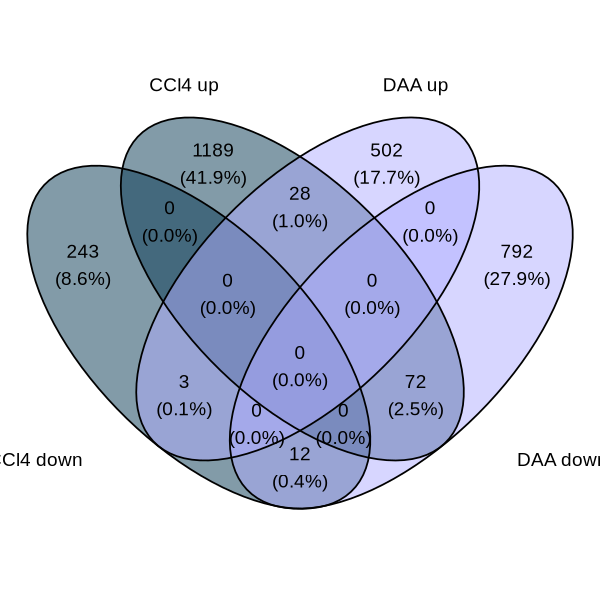

In [176]:
options(repr.plot.width = 5, repr.plot.height = 5)
venn_dataframe <- list("CCl4 down" = ccl4_c_down,
                       "CCl4 up" = ccl4_c_up,
                        "DAA up" = rownames(cured_results %>% as.data.frame() %>% filter(padj <= 0.05 & log2FoldChange >= 0.5)),
                        "DAA down" = rownames(cured_results %>% as.data.frame() %>% filter(padj <= 0.05 & log2FoldChange <= -0.5)))

ggvenn(venn_dataframe,
  fill_color = c("#063852", "#063852", "#afaeff", "#afaeff"),
  stroke_size = 0.5, set_name_size = 4)

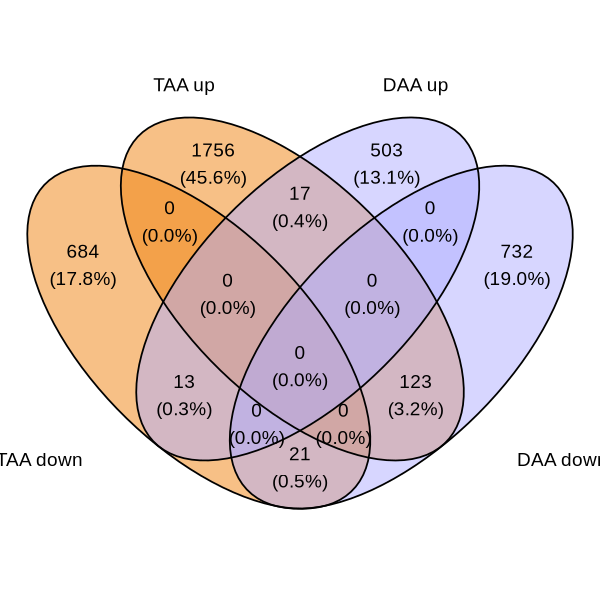

In [177]:
venn_dataframe <- list("TAA down" = taa_c_down,
                       "TAA up" = taa_c_up,
                        "DAA up" = rownames(cured_results %>% as.data.frame() %>% filter(padj <= 0.05 & log2FoldChange >= 0.5)),
                        "DAA down" = rownames(cured_results %>% as.data.frame() %>% filter(padj <= 0.05 & log2FoldChange <= -0.5)))

ggvenn(venn_dataframe,
  fill_color = c("#F0810F", "#F0810F", "#afaeff", "#afaeff"),
  stroke_size = 0.5, set_name_size = 4)